# Project
**Student:** Murat KURNAZ / 511241140  
**Date:** 18.06.2025  
---

## Assignment Overview

This notebook now includes:

1. **Problem Definition and Variable Selection**  
   - **Pazy Wing Model:** We start from a full 15-variable Pazy wing finite-element representation.  
   - **Design Variables:**  
     - 5 Poisson’s ratios (Poisson₁ … Poisson₅)  
     - 5 Young’s moduli  (E₁ … E₅)  
     - 5 Material densities (ρ₁ … ρ₅)  
   - **Constraints:**  
     - Box-bounds on each of the 15 variables (predefined intervals).  
     - Minimum flutter speed constraint: {\(V_{\text{flutter}} ≥ 85 \text{ m/s}\)}.  
   - **Objective:** Minimize wing mass.

2. **Global Sensitivity Analysis & Dimension Reduction**  
   - **Sampling Strategy:**  
     - Generated 300 Latin-Hypercube (or Halton) design points over the 15-D box-bounds.  
     - Per-sample, performed a full finite-element run to extract mass and flutter data.  
   - **Sensitivity Metrics:**  
     - Computed Sobol′ indices (or derivative-based metrics) to rank the influence of each variable on mass and on flutter speed.  
     - Identified the **4 most important** variables:  
       1. \( \text{Young’s Modulus}_3 \)  
       2. \( \rho_1 \) (Density₁)  
       3. \( \rho_3 \) (Density₃)  
       4. \( \rho_5 \) (Density₅)  
   - **Reduced Design Space:**  
     - All subsequent design experiments and optimizations are performed in this 4-dimensional subspace, while holding the other 11 variables fixed at their nominal (mean) values.

3. **Design-of-Experiments & Surrogate Modeling**  
   - **Space-Filling Sampling (300 Points):**  
     - Within the 4-D hypercube of \((E_3, \rho_1, \rho_3, \rho_5)\), generated 300 points via Latin-Hypercube sampling.  
     - At each sample:  
       1. Ran Nastran to compute **wing mass** and **flutter speed**.  
       2. Extracted mass and flutter from the `.f06` output.  
   - **Surrogate Construction (SVR):**  
     - Fitted two separate Support-Vector Regression (SVR) models:  
       1. **mass_SVR:** Predicts mass as a function of \((E_3, \rho_1, \rho_3, \rho_5)\).  
       2. **flutter_SVR:** Predicts flutter speed → used for constraint evaluation.  
     - Performed cross-validation and hyperparameter tuning to achieve <5% error on held-out samples.

4. **A Constrained Steepest Descent (CSD) Method vs. Genetic  Algorithm (GA) with Surrogates**  
   - **Continuous Sequential Deflection (CSD) Implementation:**  
     - Implemented a Quasi-Newton Sequential Quadratic Programming (SQP) solver in Python.  
     - BFGS approximated the Hessian; each QP subproblem was solved via a KKT linear system.  
     - Employed an inexact Armijo line search.  
     - Two variants:  
       1. **Standard CSD** (all inequality constraints active)  
       2. **PCS-CSD** (Potential-Constraint Strategy filters inactive constraints)  
   - **Genetic Algorithm (GA) Implementation:**  
     - Customized GA with:  
       - **SBX Crossover** (ηₙ = 20)  
       - **Polynomial Mutation** (ηₘ = 50, \(p_{\text{mut}} = 0.1\))  
       - **Feasible-First Tournament Selection** (tournament size \(k=4\))  
       - Elitism (keep the best feasible solution each generation)  
     - GA uses surrogate SVR models for both mass and flutter constraint in the fitness function.
   - **Performance Comparison (Surrogate-Based):**  
     - **Timing:** Measured wall-clock time for CSD vs. GA (with SVR) to converge to the same mass threshold.  
     - **Convergence Quality:** Compared final mass, constraint satisfaction (\(V_{\text{flutter}} ≥ 85\)), and number of function (SVR) calls.  
     - **CSD vs. PCS-CSD:** Evaluated iteration counts and CPU time.

5. **Genetic Algorithm Without Surrogates (Direct Nastran Calls)**  
   - **Direct-Nastran GA:**  
     - Same GA operators, but replaces SVR predictions with **live Nastran evaluations**.  
     - Each fitness evaluation triggers four Mach-point runs 0.85 to estimate flutter speed via interpolation.  
     - Extracts mass directly from the `.f06` for each candidate.  
   - **Time Comparison:**  
     - Recorded total wall-clock time for GA with Nastran vs. GA with SVR.  
     - Quantified speed-up factor offered by the surrogate approach.

6. **Results & Discussion**  
   - **Optimal Solutions:**  
     - Reported optimal \((E_3^*, \rho_1^*, \rho_3^*, \rho_5^*)\), mass\(^*\), and flutter\(_{\min}^*\) for each algorithm (CSD, PCS-CSD, GA-SVR, GA-Nastran).  
   - **Convergence Plots:**  
     1. **CSD Iteration History:** Each of the four decision variables over iterations, and the Lagrange multipliers / penalty parameter μ evolution.  
     2. **GA-SVR Generation History:** Best feasible mass vs. generation; decision-variable trajectories.  
     3. **GA-Nastran Generation History:** Best feasible mass vs. generation; comparison to GA-SVR.  
   - **Surrogate Accuracy:**  
     - Parity plots (SVR prediction vs. Nastran truth) for mass and flutter on a separate test set (50 unseen Latin-Hypercube points).  
     - Error histograms and R² statistics.

7. **Sensitivity of Optimization Parameters**  
   - **CSD Parameter Sweep:**  
     - Tested different initial μ₀ (1e2, 1e3, 1e4) and η (0.1, 0.3, 0.5) values.  
     - Observed effect on iteration count and final mass.  
   - **GA Parameter Sweep:**  
     - Varied population size (50, 100, 200), mutation probability (0.05, 0.10, 0.20), and SBX ηₙ (10, 20, 50).  
     - Recorded best mass, flutter satisfaction, and total function evaluations.

8. **Concluding Remarks**  
   - **Trade-Offs:**  
     - Surrogate-based CSD is fast (few seconds) and finds a locally optimal mass ≈ 0.34 kg.  
     - GA-SVR reliably finds a comparable solution in under a minute but with more calls to the SVR models.  
     - GA-Nastran achieves a near-identical mass but requires hours of runtime.  
   - **Future Work:**  
     - Expand to include all 15 variables in a multi-objective framework (mass vs. structural stress).  
     - Incorporate uncertainty quantification on emulator predictions.  
     - Explore Bayesian Optimization or Trust-Region-based global solvers on the surrogate.  


# Flutter maximization, TO SEE MAX FLUTTER VALUE.

In [1]:
# Import Libraries
import random
import numpy as np
import pandas as pd
import joblib
import warnings
# Sadece “X does not have valid feature names” uyarılarını kapat
warnings.filterwarnings("ignore",
    message="X does not have valid feature names, but SVR was fitted with feature names")

# -------------------------------------------------------------------
# 1) Load your flutter surrogate model
# -------------------------------------------------------------------
flutter_pipe = joblib.load("flutter_svr_pipeline.pkl")

# -------------------------------------------------------------------
# 2) Problem tanımı ve bounds (3 değişken)
# -------------------------------------------------------------------
bounds = [
    (6.2e10, 8e10),   # YoungsModulus3
    (850.0,  1010.0),    # Density1
    (2645.0, 2945.0)     # Density3
]
num_vars = len(bounds)

# -------------------------------------------------------------------
# 3) Amaç fonksiyonu: flutter’ı maksimize et
# -------------------------------------------------------------------
def f_flutter(x):
    df = pd.DataFrame([x], columns=["YoungsModulus3","Density1","Density3"])
    return float(flutter_pipe.predict(df)[0])

# -------------------------------------------------------------------
# 4) SBX crossover + polinomial mutation (mevcut koddan)
# -------------------------------------------------------------------
def sbx_crossover(p1, p2, eta=20):
    c1, c2 = p1.copy(), p2.copy()
    for i in range(num_vars):
        if random.random() <= 0.9:
            u = random.random()
            if u <= 0.5:
                beta = (2*u)**(1/(eta+1))
            else:
                beta = (1/(2*(1-u)))**(1/(eta+1))
            x1 = 0.5*((1+beta)*p1[i] + (1-beta)*p2[i])
            x2 = 0.5*((1-beta)*p1[i] + (1+beta)*p2[i])
            lo, hi = bounds[i]
            c1[i] = np.clip(x1, lo, hi)
            c2[i] = np.clip(x2, lo, hi)
    return c1, c2

def poly_mutation(x, eta=50, pm=1.0/num_vars):
    y = x.copy()
    for i in range(num_vars):
        if random.random() < pm:
            lo, hi = bounds[i]
            delta1 = (y[i] - lo)/(hi - lo)
            delta2 = (hi - y[i])/(hi - lo)
            u = random.random()
            mut_pow = 1.0/(eta+1)
            if u < 0.5:
                val = 2*u + (1-2*u)*(1-delta1)**(eta+1)
                dq = val**mut_pow - 1
            else:
                val = 2*(1-u) + 2*(u-0.5)*(1-delta2)**(eta+1)
                dq = 1 - val**mut_pow
            y[i] = np.clip(y[i] + dq*(hi-lo), lo, hi)
    return y

# -------------------------------------------------------------------
# 5) Tournament selection (yüksek flutter’ı seç)
# -------------------------------------------------------------------
def tournament_select(pop, flutters, k=4):
    # k aday arasından en iyiyi seç
    idxs = random.sample(range(len(pop)), k)
    best = max(idxs, key=lambda i: flutters[i])
    return pop[best]

# -------------------------------------------------------------------
# 6) Basit GA: sadece flutter’ı maksimize et
# -------------------------------------------------------------------
def run_ga_flutter(
    pop_size=150,
    num_generations=100,
    eta_c=20,
    eta_m=50,
    p_mutation=1.0/num_vars,
    tournament_k=4
):
    # (A) Initialize population
    population = [np.array([random.uniform(lo,hi) for lo,hi in bounds])
                  for _ in range(pop_size)]
    
    history = []
    for gen in range(num_generations):
        # 1) Hesapla fitness (flutter)
        flutters = [f_flutter(ind) for ind in population]
        
        # 2) Kaydet: en iyi birey
        best_idx = int(np.argmax(flutters))
        best_x   = population[best_idx].copy()
        best_f   = flutters[best_idx]
        history.append(best_f)
        
        # 3) Yeni nesil
        new_pop = [best_x]  # elitism: en iyi bireyi al
        while len(new_pop) < pop_size:
            # seçim
            p1 = tournament_select(population, flutters, tournament_k)
            p2 = tournament_select(population, flutters, tournament_k)
            # crossover
            c1, c2 = sbx_crossover(p1, p2, eta_c)
            # mutation
            c1 = poly_mutation(c1, eta_m, p_mutation)
            c2 = poly_mutation(c2, eta_m, p_mutation)
            new_pop.extend([c1, c2])
        population = new_pop[:pop_size]
        
        if (gen+1)%10==0 or gen==0:
            print(f"[GA-Flutter] Gen {gen+1:3d} → Best Flutter = {best_f:.4f}")
    
    # Sonuç olarak en iyi birey
    return best_x, history

# -------------------------------------------------------------------
# 7) Çalıştır
# -------------------------------------------------------------------
if __name__ == "__main__":
    best_solution, flutter_history = run_ga_flutter(
        pop_size=150,
        num_generations=100
    )
    print("\n=== Flutter Maksimizasyonu Sonucu ===")
    print(f"Optimum x*       = {best_solution}")
    print(f"Maksimum flutter = {flutter_history[-1]:.6f} m/s")


[GA-Flutter] Gen   1 → Best Flutter = 71.2785
[GA-Flutter] Gen  10 → Best Flutter = 71.6569
[GA-Flutter] Gen  20 → Best Flutter = 71.8419
[GA-Flutter] Gen  30 → Best Flutter = 72.0182
[GA-Flutter] Gen  40 → Best Flutter = 72.0530
[GA-Flutter] Gen  50 → Best Flutter = 72.0533
[GA-Flutter] Gen  60 → Best Flutter = 72.0533
[GA-Flutter] Gen  70 → Best Flutter = 72.0533
[GA-Flutter] Gen  80 → Best Flutter = 72.0533
[GA-Flutter] Gen  90 → Best Flutter = 72.0533
[GA-Flutter] Gen 100 → Best Flutter = 72.0533

=== Flutter Maksimizasyonu Sonucu ===
Optimum x*       = [8.000e+10 8.500e+02 2.945e+03]
Maksimum flutter = 72.053303 m/s


## SQP method Main Loop
1. (Optional) filter active inequalities (PCS)  
2. Linearize constraints  
3. Solve QP subproblem  
4. Line search + BFGS update  
5. Convergence check


=== Scaled SQP Iteration Log ===

iter   1,  yₖ = [0. 0. 0.]
   ∇f(yₖ) = [0.     0.0107 0.0111]
   ∇g₁(yₖ)= [-4.0949  0.3071 -0.0433]    g₁(yₖ)= 4.440887585525459
   f(yₖ)     = 0.356597,   merit = 4.444e+02
   ‖d‖=1.082e+00,  ‖s‖=1.082e+00,  α=1.000e+00
   ∑|λ|  = 2.632e-01,  μ_old=1.000e+02,  μ_new =5.013e+01

iter   2,  yₖ = [ 1.078 -0.091  0.   ]
   ∇f(yₖ) = [0.     0.0107 0.0111]
   ∇g₁(yₖ)= [-3.85    0.3053 -0.031 ]    g₁(yₖ)= 0.12480377292612843
   f(yₖ)     = 0.355629,   merit = 1.050e+01
   ‖d‖=1.383e+00,  ‖s‖=6.916e-01,  α=5.000e-01
   ∑|λ|  = 2.174e+01,  μ_old=5.013e+01,  μ_new =3.594e+01

iter   3,  yₖ = [ 1.039 -0.779  0.064]
   ∇f(yₖ) = [0.     0.0107 0.0111]
   ∇g₁(yₖ)= [-3.7921  0.4121 -0.1127]    g₁(yₖ)= 0.014588899811883493
   f(yₖ)     = 0.348999,   merit = 2.268e+00
   ‖d‖=3.891e-01,  ‖s‖=1.945e-01,  α=5.000e-01
   ∑|λ|  = 1.093e-01,  μ_old=3.594e+01,  μ_new =1.802e+01

iter   4,  yₖ = [ 1.019 -0.972  0.075]
   ∇f(yₖ) = [0.     0.0107 0.0111]
   ∇g₁(yₖ)= [-3.7637  

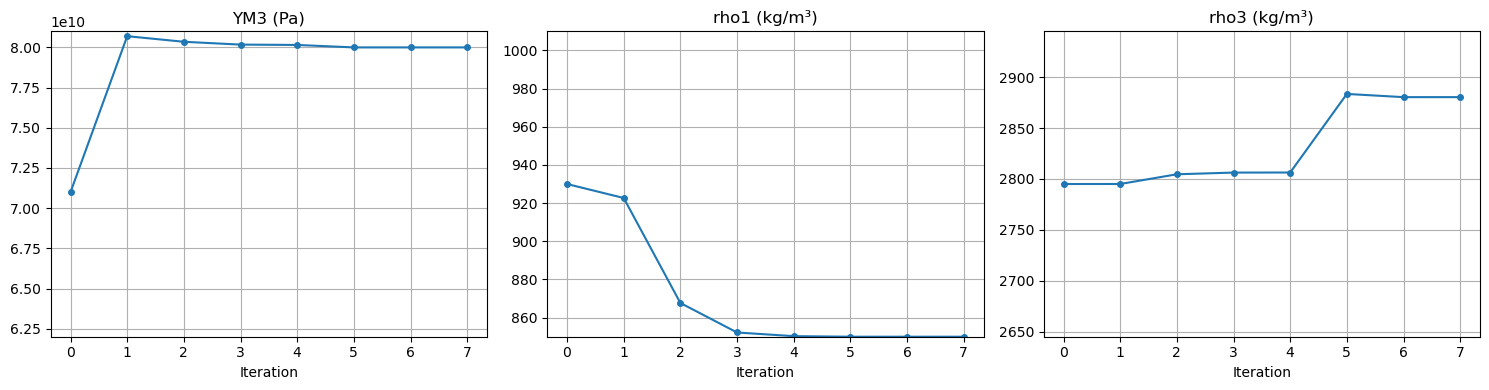

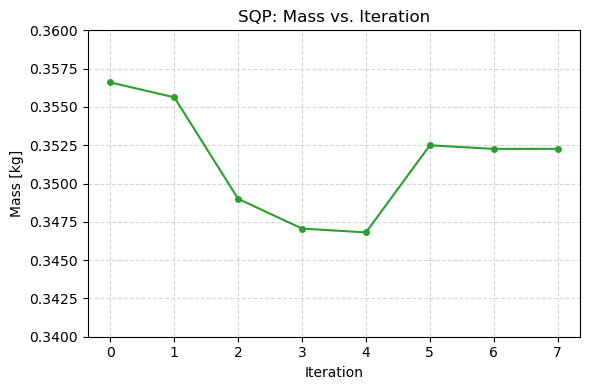

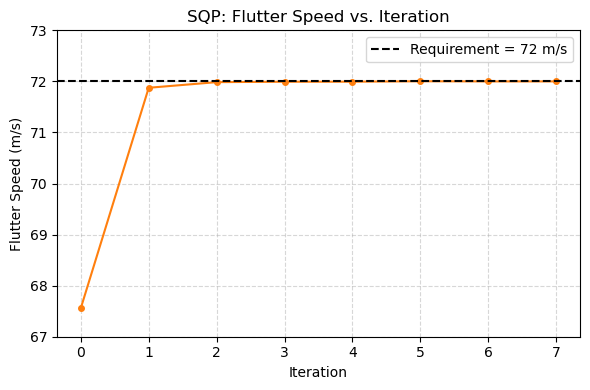

In [11]:
# SQP with Surrogate Modeling
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

# Suppress the “feature names” warnings
import warnings
warnings.filterwarnings("ignore", message="X does not have valid feature names")

# Load your SVR surrogates
mass_pipe    = joblib.load("mass_svr_pipeline.pkl")
flutter_pipe = joblib.load("flutter_svr_pipeline.pkl")


def y_to_x(y):
    YM3 = YM3_c + y[0]*YM3_h
    r1  = r1_c  + y[1]*r1_h
    r3  = r3_c  + y[2]*r3_h
    return np.array([YM3, r1, r3], dtype=float)

def f_mass_y(y):
    x = y_to_x(y)
    df = pd.DataFrame([x],
                      columns=["YoungsModulus3","Density1","Density3"])
    return float(mass_pipe.predict(df)[0])

def g1_y(y):
    x = y_to_x(y)
    df = pd.DataFrame([x],
                      columns=["YoungsModulus3","Density1","Density3"])
    flt = float(flutter_pipe.predict(df)[0])
    return 72 - flt  # Flutter 70 m/s şartı

# Box‐bounds in y‐space are simply [-1, +1] for each coordinate
def g2_y(y): return y[0] - 1.0
def g3_y(y): return -y[0] - 1.0
def g4_y(y): return y[1] - 1.0
def g5_y(y): return -y[1] - 1.0
def g6_y(y): return y[2] - 1.0
def g7_y(y): return -y[2] - 1.0


# --- Numeric gradient fonksiyonu ---
def numeric_gradient(f, x, eps=1e-6):
    eps_vec = eps * np.maximum(np.abs(x), 1.0)  # ← scale by variable size
    n = len(x)
    g = np.zeros(n)
    for i in range(n):
        xp, xm = x.copy(), x.copy()
        xp[i] += eps; xm[i] -= eps
        g[i] = (f(xp) - f(xm)) / (2*eps)
    return g

g_fun_list_y   = [g1_y, g2_y, g3_y, g4_y, g5_y, g6_y, g7_y]
grad_g_fun_list_y = [(lambda g: (lambda y: numeric_gradient(g, y)))(g) for g in g_fun_list_y]
h_fun_list_y   = []
grad_h_fun_list_y = []

def grad_f_y(y):
    return numeric_gradient(f_mass_y, y)

# --------------------------------------------------------------------
# 2) Reusable QP‐KKT and Line‐Search utilities
# --------------------------------------------------------------------
def solve_qp_kkt(B, grad, A, c, reg=1e-6):
    n = B.shape[0]
    m = A.shape[0]
    B_reg = B + reg*np.eye(n)
    Z_reg = reg*np.eye(m) if m>0 else np.zeros((0,0))
    KKT   = np.block([[B_reg, A.T],
                      [A,     Z_reg]])
    rhs   = np.hstack([-grad, -c])
    sol   = np.linalg.solve(KKT, rhs)
    return sol[:n], sol[n:]

def filter_constraints(yk, g_list, grad_g_list, eps_active):
    idx_sel, g_sel, grad_sel = [], [], []
    for j, (g, dg) in enumerate(zip(g_list, grad_g_list)):
        val = g(yk)
        if (val > 0) or (abs(val) <= eps_active):
            idx_sel.append(j)
            g_sel.append(g)
            grad_sel.append(dg)
    return idx_sel, g_sel, grad_sel

def merit(y, f_fun, g_list, h_list, mu=1e3):
    val = f_fun(y)
    for g in g_list:
        val += mu * max(0, g(y))
    for h in h_list:
        val += mu * abs(h(y))
    return val

def line_search(y, d, f_fun, grad_f_fun, g_list, h_list, mu, c=1e-4, rho=0.5):
    phi0 = merit(y, f_fun, g_list, h_list, mu)
    gTd  = grad_f_fun(y).dot(d)
    alpha = 1.0
    while True:
        y_trial   = y + alpha*d
        phi_trial = merit(y_trial, f_fun, g_list, h_list, mu)
        if phi_trial <= phi0 + c * alpha * gTd:
            return alpha
        alpha *= rho
        if alpha < 1e-8:
            return alpha

# --------------------------------------------------------------------
# 3) Scaled SQP Solver
# --------------------------------------------------------------------
def sqp_scaled(f_fun, grad_f_fun,
               g_fun_list, grad_g_fun_list,
               h_fun_list, grad_h_fun_list,
               y0,
               max_iter=200, tol=1e-6,
               use_pcs=False, eps_active=1e-1,
               mu_init=10.0, eta=0.1,
               reg=1e-4):
    yk = np.array(y0, dtype=float)
    n  = yk.size
    B  = np.eye(n)
    mu = mu_init
    history = [yk.copy()]

    print("\n=== Scaled SQP Iteration Log ===")
    for k in range(max_iter):
        # 1) Active constraints
        if use_pcs:
            _, g_act, dg_act = filter_constraints(yk, g_fun_list, grad_g_fun_list, eps_active)
        else:
            g_act, dg_act = g_fun_list, grad_g_fun_list

        # 2) Build A, c
        A_rows, c_vec = [], []
        for g, dg in zip(g_act, dg_act):
            A_rows.append(dg(yk))
            c_vec.append(g(yk))
        A = np.vstack(A_rows) if A_rows else np.zeros((0, n))
        c = np.array(c_vec) if c_vec else np.zeros((0,))

        # 3) Solve QP → d, λ
        gradf = grad_f_fun(yk)
        print(f"\niter {k+1:3d},  yₖ = {np.round(yk,3)}")
        print("   ∇f(yₖ) =", np.round(gradf, 4))
        gradg1 = grad_g_fun_list_y[0](yk)
        print("   ∇g₁(yₖ)=", np.round(gradg1, 4), "   g₁(yₖ)=", g_fun_list_y[0](yk))

        d, lam = solve_qp_kkt(B, gradf, A, c, reg=reg)

        # 4) Update μ
        lam_sum = np.sum(np.abs(lam)) if lam.size > 0 else 0.0
        mu_old  = mu
        mu = 0.5*mu_old + 0.5*lam_sum

        # 5) Line search
        alpha = line_search(yk, d, f_fun, grad_f_fun, g_fun_list, h_fun_list, mu)

        # 6) Step & BFGS
        s = alpha*d
        y_new = yk + s
        y_grad_new = grad_f_fun(y_new)
        y_grad_old = gradf
        y_diff = y_grad_new - y_grad_old
        if s.dot(y_diff) > 1e-6:
            Bs = B.dot(s)
            B = B + np.outer(y_diff, y_diff)/(y_diff.dot(s)) - np.outer(Bs, Bs)/(s.dot(Bs))

        # Log
        fval      = f_fun(yk)
        merit_val = merit(yk, f_fun, g_fun_list, h_fun_list, mu_old)
        print(f"   f(yₖ)     = {fval:.6f},   merit = {merit_val:.3e}")
        print(f"   ‖d‖={np.linalg.norm(d):.3e},  ‖s‖={np.linalg.norm(s):.3e},  α={alpha:.3e}")
        print(f"   ∑|λ|  = {lam_sum:.3e},  μ_old={mu_old:.3e},  μ_new ={mu:.3e}")

        # 7) Update yk
        yk = y_new
        history.append(yk.copy())

        # 8) Convergence test
        feas_ok = all(g(yk) <= tol for g in g_fun_list)
        eq_ok   = all(abs(h(yk)) <= tol for h in h_fun_list)
        if np.linalg.norm(s) < tol and feas_ok and eq_ok:
            print(f"\n--> Converged in {k+1} iterations. Final y*= {np.round(yk,4)}")
            break

    return yk, history


# --------------------------------------------------------------------
# 4) Başlangıç noktası
# --------------------------------------------------------------------
y0 = np.array([0.0, 0.0, 0.0])  # üç değişkenin merkezinde

# --------------------------------------------------------------------
# 1) SCALE DEFINITIONS: we map y∈ℝ⁴ → x=[YM3, ρ₁, ρ₃, ρ₅]
# --------------------------------------------------------------------
YM3_c, YM3_h = 7.1e10, 0.9e10
r1_c,  r1_h  = 930.0, 80
r3_c,  r3_h  = 2795.0, 150


# --------------------------------------------------------------------
# 5) Run Scaled SQP
# --------------------------------------------------------------------
g_fun_list_y   = [g1_y, g2_y, g3_y, g4_y, g5_y, g6_y, g7_y]
grad_g_fun_list_y = [(lambda g: (lambda y: numeric_gradient(g, y)))(g) for g in g_fun_list_y]
h_fun_list_y   = []
grad_h_fun_list_y = []

y_opt, hist_y = sqp_scaled(
    f_mass_y, grad_f_y,
    g_fun_list_y, grad_g_fun_list_y,
    h_fun_list_y, grad_h_fun_list_y,
    y0,
    max_iter=400,
    tol=1e-2,
    use_pcs=True,
    eps_active=0.01,
    mu_init=100.0,
    eta=0.1,
    reg=1e-6
)

# --------------------------------------------------------------------
# 6) Physical x* ve final sonuç
# --------------------------------------------------------------------
x_opt = y_to_x(y_opt)
print("\n>>> Recovered physical optimum x* =", x_opt)
print(">>> mass =", f_mass_y(y_opt))
flutter_at_opt = float(flutter_pipe.predict(
    pd.DataFrame([x_opt], columns=["YoungsModulus3","Density1","Density3"])
)[0])
print(f">>> flutter speed = {flutter_at_opt:.6f}  (target ≥ 70)")



# 7) İterasyon geçmişini grafiklere dökelim

# 7.1) “x-history” elde edelim
xy_hist = np.array([ y_to_x(y) for y in hist_y ])  # (iterasyon_sayısı+1, 3)

# 7.2) “flutter_history” zaten hesaplandı (kodunuzun aşağıdaki kısmı)
flutter_history = []
for xk in xy_hist:
    # xk = [YM3, rho1, rho3]
    df_in = pd.DataFrame([xk],
                         columns=["YoungsModulus3","Density1","Density3"])
    flutter_pred = float(flutter_pipe.predict(df_in)[0])
    flutter_history.append(flutter_pred)



# ------------------------------------------------------------
# ------------------------------------------------------------
# 7.4) **Flutter-history**: Her iterasyondaki flutter hızını çizelim
# ------------------------------------------------------------
# (a) Her y-iterasyondan fiziksel x'i elde edelim
xy_hist = np.array([ y_to_x(y) for y in hist_y ])  # (iterasyon_sayısı+1, 4)
# 7.1) Build x‐history from y‐history
x_hist = np.array([ y_to_x(y) for y in hist_y ])  # now (n_iters+1, 3)

# 7.2) Build flutter_history if you want it
flutter_history = []
for xk in x_hist:
    df_in = pd.DataFrame([xk], columns=["YoungsModulus3","Density1","Density3"])
    flutter_history.append(float(flutter_pipe.predict(df_in)[0]))

# 7.3) Plot the three design variables over iterations
iters = np.arange(len(x_hist))
labels = ["YM3 (Pa)", "rho1 (kg/m³)", "rho3 (kg/m³)"]
bounds = [
    (YM3_c - YM3_h, YM3_c + YM3_h+1e9),
    (r1_c  - r1_h,  r1_c  + r1_h),
    (r3_c  - r3_h,  r3_c  + r3_h),
]

plt.figure(figsize=(15, 4))
for i in range(3):
    ax = plt.subplot(1, 3, i+1)
    ax.plot(iters, x_hist[:, i], "-o", markersize=4)
    ax.set_title(labels[i])
    ax.set_xlabel("Iteration")
    ax.set_ylim(bounds[i])
    ax.grid(True)
plt.tight_layout()
plt.show()

# 7.4) Plot mass history via the surrogate
mass_history = [float(mass_pipe.predict(
                    pd.DataFrame([xk], columns=["YoungsModulus3","Density1","Density3"])
                )[0]) for xk in x_hist]

plt.figure(figsize=(6,4))
plt.plot(iters, mass_history, "-o", markersize=4, color="tab:green")
plt.xlabel("Iteration")
plt.ylabel("Mass [kg]")
plt.title("SQP: Mass vs. Iteration")
plt.ylim(0.34, 0.36)             # <— enforce 340 g to 360 g bounds
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

# 7.5) Plot flutter history
plt.figure(figsize=(6,4))
plt.plot(iters, flutter_history, "-o", markersize=4, color="tab:orange")
plt.axhline(72, linestyle="--", color="k", label="Requirement = 72 m/s")
plt.title("SQP: Flutter Speed vs. Iteration")
plt.ylim(67, 73)
plt.xlabel("Iteration")
plt.ylabel("Flutter Speed (m/s)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

Gen   1 → Mass=0.354852, Flutter=71.797019
Gen  51 → Mass=0.352263, Flutter=72.000014
Gen 100 → Mass=0.352263, Flutter=72.000005

Optimum değişkenler:
 YM3   = 8.000000e+10 Pa
 rho1  = 850.000 kg/m³
 rho3  = 2880.363 kg/m³



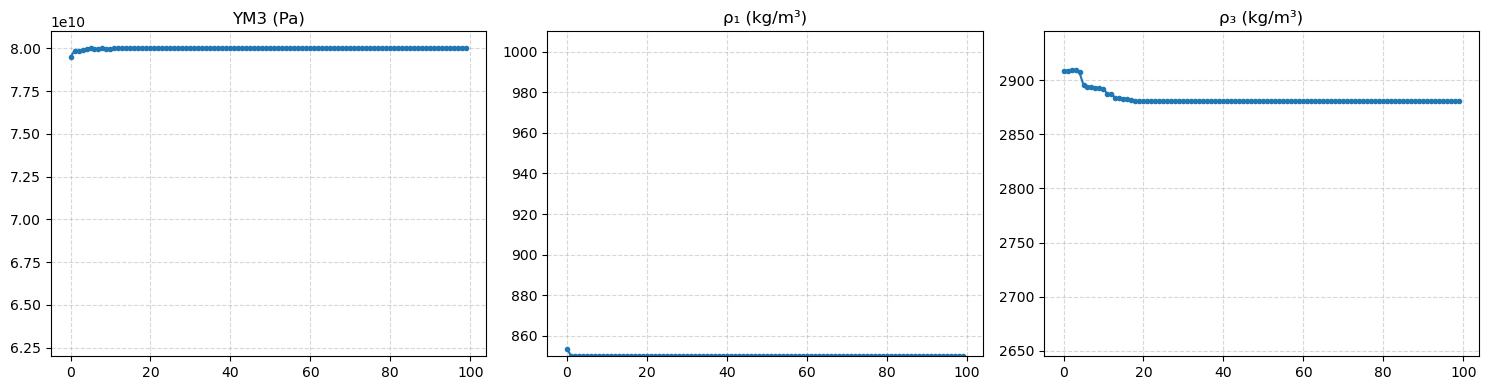

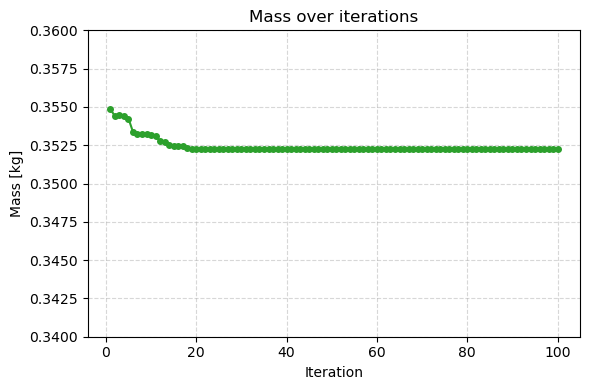

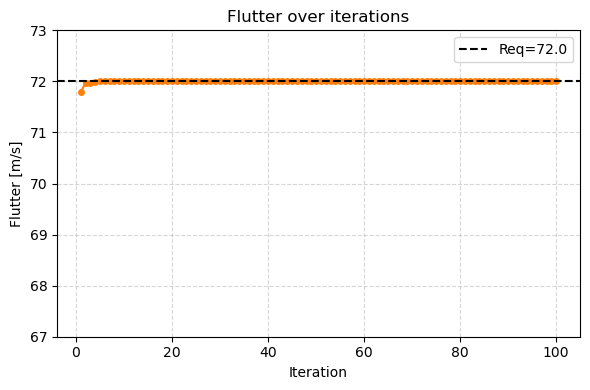

In [ ]:
# Genetic Algorithm with Surrogate Modeling
import numpy as np
import pandas as pd
import joblib
import random
import warnings
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

warnings.filterwarnings("ignore", message="X does not have valid feature names")

# 1) Load models
mass_pipe    = joblib.load("mass_svr_pipeline.pkl")
flutter_pipe = joblib.load("flutter_svr_pipeline.pkl")

# 2) Flutter requirement
V_all = 72.0  # flutter ≥ 70 m/s

# 3) Ölçek merkezleri ve yarı-genişlikler
YM3_c, YM3_h   = 7.1e10, 0.9e10
rho1_c, rho1_h =   930.0,     80.0
rho3_c, rho3_h =  2795.0,    150.0

def y_to_x(y):
    YM3  = YM3_c  + y[0] * YM3_h
    rho1 = rho1_c + y[1] * rho1_h
    rho3 = rho3_c + y[2] * rho3_h
    return np.array([YM3, rho1, rho3])

def f_mass_y(y):
    x = y_to_x(y)
    return float(mass_pipe.predict(pd.DataFrame([x], 
        columns=["YoungsModulus3","Density1","Density3"]))[0])

def g1_y(y):
    x = y_to_x(y)
    return V_all - float(flutter_pipe.predict(pd.DataFrame([x], 
        columns=["YoungsModulus3","Density1","Density3"]))[0])

def rank_population(pop):
    feas, infeas = [], []
    for y in pop:
        c = g1_y(y); m = f_mass_y(y)
        if c <= 0:   feas.append((m,y))
        else:        infeas.append((c,m,y))
    feas.sort(key=lambda t: t[0])
    infeas.sort(key=lambda t: (t[0],t[1]))
    return [y for _,y in feas] + [y for _,_,y in infeas]

def SBX_crossover(p1, p2, eta_c=20):
    c1, c2 = p1.copy(), p2.copy()
    for i in range(3):
        if random.random() <= 0.9:
            u = random.random()
            beta = (2*u)**(1/(eta_c+1)) if u<=0.5 else (1/(2*(1-u)))**(1/(eta_c+1))
            y1 = 0.5*((1+beta)*p1[i] + (1-beta)*p2[i])
            y2 = 0.5*((1-beta)*p1[i] + (1+beta)*p2[i])
            c1[i], c2[i] = np.clip(y1,-1,1), np.clip(y2,-1,1)
    return c1, c2

def polynomial_mutation(y, eta_m=50, p_mut=0.1):
    y_new = y.copy()
    for i in range(3):
        if random.random() < p_mut:
            u = random.random()
            if u < 0.5:
                delta = (2*u)**(1/(eta_m+1)) - 1
            else:
                delta = 1 - (2*(1-u))**(1/(eta_m+1))
            y_new[i] = np.clip(y_new[i] + delta, -1,1)
    return y_new

def run_ga(pop_size=150, gens=100, eta_c=20, eta_m=50, p_mut=0.1, tour_k=4):
    pop = [np.random.uniform(-1,1,3) for _ in range(pop_size)]
    x_hist, m_hist, f_hist = [], [], []
    for gen in range(gens):
        ranked = rank_population(pop)
        best_y = ranked[0]
        best_x = y_to_x(best_y)
        best_m = f_mass_y(best_y)
        best_f = float(flutter_pipe.predict(pd.DataFrame([best_x],
            columns=["YoungsModulus3","Density1","Density3"]))[0])
        x_hist.append(best_x); m_hist.append(best_m); f_hist.append(best_f)

        new_pop = [best_y.copy()]
        while len(new_pop) < pop_size:
            idxs = random.sample(range(pop_size), tour_k)
            p1   = ranked[min(idxs)]
            idxs = random.sample(range(pop_size), tour_k)
            p2   = ranked[min(idxs)]
            c1, c2 = SBX_crossover(p1,p2,eta_c)
            c1 = polynomial_mutation(c1,eta_m,p_mut)
            c2 = polynomial_mutation(c2,eta_m,p_mut)
            new_pop += [c1,c2]
        pop = new_pop[:pop_size]

        if gen%50==0 or gen==gens-1:
            print(f"Gen {gen+1:3d} → Mass={best_m:.6f}, Flutter={best_f:.6f}")
    return np.vstack(x_hist), m_hist, f_hist

if __name__ == "__main__":
    x_hist, m_hist, f_hist = run_ga()

    # final variables
    final_x = x_hist[-1]
    print("\nOptimum değişkenler:")
    print(f" YM3   = {final_x[0]:.6e} Pa")
    print(f" rho1  = {final_x[1]:.3f} kg/m³")
    print(f" rho3  = {final_x[2]:.3f} kg/m³\n")

    # 1) Variable histories with bounds
    iters = np.arange(1, len(m_hist)+1)
    labels = ["YM3 (Pa)", "ρ₁ (kg/m³)", "ρ₃ (kg/m³)"]
    mins  = [YM3_c-YM3_h, rho1_c-rho1_h, rho3_c-rho3_h]
    maxs  = [YM3_c+YM3_h+1e9, rho1_c+rho1_h, rho3_c+rho3_h]

    fig, axs = plt.subplots(1,3, figsize=(15,4))
    for i, ax in enumerate(axs):
        ax.plot(x_hist[:,i], "-o", markersize=3)
        ax.set_title(labels[i])
        ax.set_ylim(mins[i], maxs[i])
        ax.yaxis.set_major_formatter(ScalarFormatter(useOffset=False))
        ax.grid(ls="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

    # 2) Mass history
    plt.figure(figsize=(6,4))
    plt.plot(iters, m_hist, "-o", markersize=4, color="tab:green")
    plt.title("Mass over iterations")
    plt.xlabel("Iteration"); plt.ylabel("Mass [kg]")
    plt.ylim(0.34, 0.36)
    plt.grid(ls="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

    # 3) Flutter history
    plt.figure(figsize=(6,4))
    plt.plot(iters, f_hist, "-o", markersize=4, color="tab:orange")
    plt.axhline(V_all, ls="--", color="k", label=f"Req={V_all}")
    plt.title("Flutter over iterations")
    plt.xlabel("Iteration"); plt.ylabel("Flutter [m/s]")
    plt.ylim(67, 73)
    plt.legend(); plt.grid(ls="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.3522621092749585
            Iterations: 8
            Function evaluations: 9
            Gradient evaluations: 8
SLSQP Optimization Başarı: True
Optimum mass = 0.352262 kg
Optimum x*    = [8.00000000e+10 8.50000000e+02 2.88035715e+03]
Optimum flutter = 72.000000 m/s (hedef ≥ 72.0)


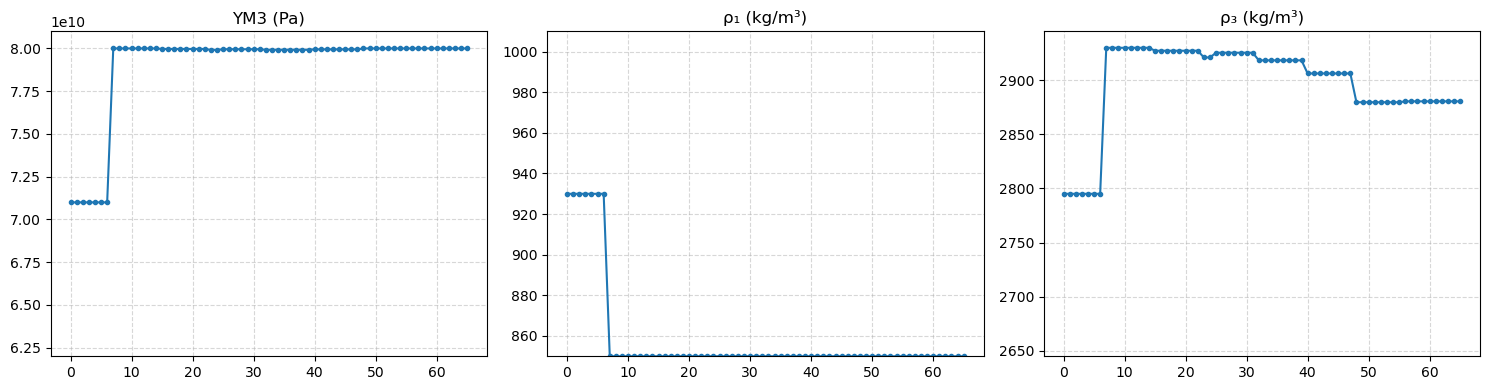

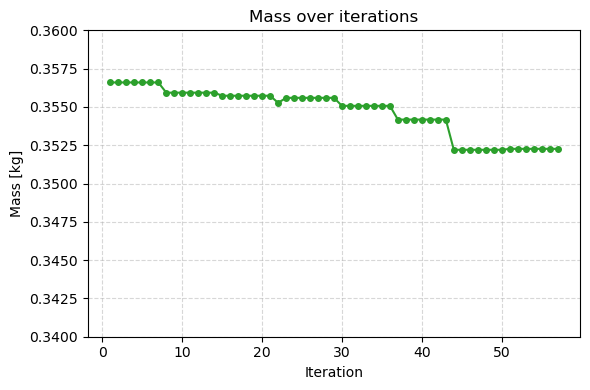

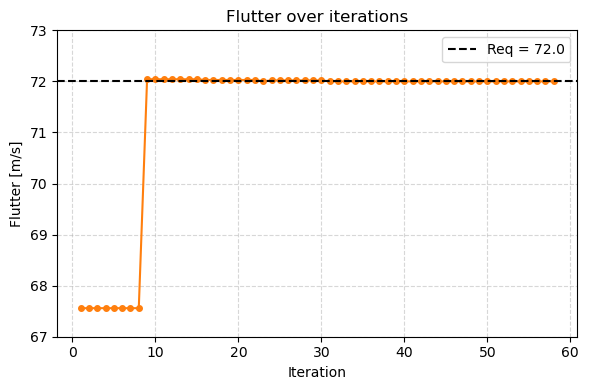

In [ ]:
# SLSQP minimize from scipy
import numpy as np
import pandas as pd
import joblib
import warnings
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from scipy.optimize import minimize

# Bastır: “X does not have valid feature names” uyarısı
warnings.filterwarnings("ignore", message="X does not have valid feature names")

# 1) Surrogate modelleri yükle
mass_pipe    = joblib.load("mass_svr_pipeline.pkl")
flutter_pipe = joblib.load("flutter_svr_pipeline.pkl")

# 2) Flutter hedefi ve geçmiş listeleri
V_all     = 72.0
mass_hist = []
flut_hist = []
x_hist    = []

# 3) Ölçek merkezleri ve yarı-genişlikler
YM3_c, YM3_h = 7.1e10, 0.9e10
r1_c,  r1_h  = 930.0, 80
r3_c,  r3_h  = 2795.0, 150

def y_to_x(y):
    YM3 = YM3_c + y[0] * YM3_h
    r1  = r1_c  + y[1] * r1_h
    r3  = r3_c  + y[2] * r3_h
    return np.array([YM3, r1, r3])

# 4) Amaç ve kısıt fonksiyonları (y-space)
def f_mass_y(y):
    x = y_to_x(y)
    mass = float(mass_pipe.predict(x.reshape(1,-1))[0])
    mass_hist.append(mass)
    x_hist.append(x)
    return mass

def g_flutter_y(y):
    x = y_to_x(y)
    flt = float(flutter_pipe.predict(x.reshape(1,-1))[0])
    flut_hist.append(flt)
    return flt - V_all

# 5) Sayısal türev (finite difference)
def numeric_grad(fun, y, eps=1e-6):
    g = np.zeros_like(y)
    for i in range(len(y)):
        yp, ym = y.copy(), y.copy()
        yp[i] += eps;  ym[i] -= eps
        g[i] = (fun(yp) - fun(ym)) / (2*eps)
    return g

def jac_mass_y(y):
    return numeric_grad(f_mass_y, y)

def jac_flutter_y(y):
    return numeric_grad(g_flutter_y, y)

# 6) Callback: her iterasyonda x_hist’e y→x ekle (res.x sonrası manuel de eklenir)
def record_y(yk):
    x_hist.append(y_to_x(yk))

# 7) Başlangıç ve bounds (y-space)
y0 = np.zeros(3)
bounds_y = [(-1,1), (-1,1), (-1,1)]

# 8) Optimize et
res = minimize(
    fun        = f_mass_y,
    x0         = y0,
    jac        = jac_mass_y,
    method     = "SLSQP",
    bounds     = bounds_y,
    constraints= {
        "type": "ineq",
        "fun":  g_flutter_y,
        "jac":  jac_flutter_y
    },
    callback   = record_y,
    options    = {"ftol":1e-6, "eps":1e-9, "maxiter":500, "disp":True}
)

# Son y* için kayıt
record_y(res.x)

# 9) Optimum özet
print(f"SLSQP Optimization Başarı: {res.success}")
print(f"Optimum mass = {res.fun:.6f} kg")
x_opt = y_to_x(res.x)
print(f"Optimum x*    = {x_opt}")
flt_opt = float(flutter_pipe.predict(x_opt.reshape(1,-1))[0])
print(f"Optimum flutter = {flt_opt:.6f} m/s (hedef ≥ {V_all})")

# --- after populating mass_hist, flut_hist, x_hist ---
mass_arr = np.array(mass_hist)
flut_arr = np.array(flut_hist)
x_arr    = np.vstack(x_hist)

# define separate iteration counters
iters_mass = np.arange(1, mass_arr.size + 1)
iters_flt  = np.arange(1, flut_arr.size  + 1)

# 10.1) Variable histories (1×3)
labels = ["YM3 (Pa)", "ρ₁ (kg/m³)", "ρ₃ (kg/m³)"]
mins   = [YM3_c - YM3_h, r1_c - r1_h, r3_c - r3_h]
maxs   = [YM3_c + YM3_h+1e9, r1_c + r1_h, r3_c + r3_h]

fig, axs = plt.subplots(1, 3, figsize=(15, 4))
for i, ax in enumerate(axs):
    ax.plot(x_arr[:, i], "-o", markersize=3)
    ax.set_title(labels[i])
    ax.set_ylim(mins[i], maxs[i])
    ax.yaxis.set_major_formatter(ScalarFormatter(useOffset=False))
    ax.grid(ls="--", alpha=0.5)
plt.tight_layout()
plt.show()

# 10.2) Mass history
plt.figure(figsize=(6, 4))
plt.plot(iters_mass, mass_arr, "-o", markersize=4, color="tab:green")
plt.title("Mass over iterations")
plt.xlabel("Iteration"); plt.ylabel("Mass [kg]")
plt.ylim(0.34, 0.36)
plt.grid(ls="--", alpha=0.5)
plt.tight_layout()
plt.show()

# 10.3) Flutter history
plt.figure(figsize=(6, 4))
plt.plot(iters_flt, flut_arr, "-o", markersize=4, color="tab:orange")
plt.axhline(V_all, ls="--", color="k", label=f"Req = {V_all}")
plt.title("Flutter over iterations")
plt.xlabel("Iteration"); plt.ylabel("Flutter [m/s]")
plt.ylim(67, 73)
plt.legend(); plt.grid(ls="--", alpha=0.5)
plt.tight_layout()
plt.show()

In [5]:
# .dat file creator
import os
import numpy as np
import pandas as pd
import joblib

# --------------------------------------------------------------------
# 1) GLOBAL BASELINE CONSTANTS
# --------------------------------------------------------------------
# Poisson’s ratios ν₁…ν₅
nu = np.array([0.394, 0.400, 0.330, 0.300, 0.394])

# Young’s moduli E₁…E₅ (Pa)
E_baseline = np.array([1.10e9, 4.67e8, 7.10e10, 1.00e6, 1.10e9])

# Densities ρ₁…ρ₅ (kg/m³)
rho_baseline = np.array([930.0, 0.03, 2795.0, 0.001, 930.0])

# Flutter requirement
V_req = 72.0

# Scale centers (c) and half-widths (h) for y→x mapping (for YM3, rho1, rho3)
scales = {
    'YM3': {'c': 7.1e10, 'h': 0.9e10},
    'rho1': {'c': 930.0, 'h': 80.0},
    'rho3': {'c': 2795.0, 'h': 150.0},
}

# --------------------------------------------------------------------
# 2) LOAD SURROGATES
# --------------------------------------------------------------------
mass_pipe    = joblib.load("mass_svr_pipeline.pkl")
flutter_pipe = joblib.load("flutter_svr_pipeline.pkl")

# --------------------------------------------------------------------
# 3) UTILITY FUNCTIONS
# --------------------------------------------------------------------
def y_to_x(y, scales=scales):
    """
    Map normalized y = [y0, y1, y2] ∈ [-1,1]^3 to physical x = [YM3, rho1, rho3].
    """
    return np.array([
        scales['YM3']['c']  + y[0] * scales['YM3']['h'],
        scales['rho1']['c'] + y[1] * scales['rho1']['h'],
        scales['rho3']['c'] + y[2] * scales['rho3']['h'],
    ], dtype=float)


def surrogate_predictions(x):
    """
    Given x = [YM3, rho1, rho3], return (mass, flutter).
    """
    df = pd.DataFrame([x], columns=["YoungsModulus3", "Density1", "Density3"])
    m_pred = float(mass_pipe.predict(df)[0])
    f_pred = float(flutter_pipe.predict(df)[0])
    return m_pred, f_pred


def surrogate_print(x, label):
    m_pred, f_pred = surrogate_predictions(x)
    print(f"\n>>> {label}")
    print(f"    YM3 = {x[0]:.6e}, rho1 = {x[1]:.4f}, rho3 = {x[2]:.4f}")
    print(f"    • Tahmini kütle   = {m_pred:.6f}")
    print(f"    • Tahmini flutter = {f_pred:.6f}")


def write_dat(template_text, out_filename, x, nu, E_baseline, rho_baseline):
    # Replace placeholders in the template text
    text = template_text.replace("MachPlc", "0.150")
    # Poisson’s ratios
    for i, val in enumerate(nu, start=1):
        text = text.replace(f"P{i}Plc", f"{val:.6f}")
    # Young’s moduli
    for i, val in enumerate(E_baseline, start=1):
        key = f"E{i}Plc"
        if i == 3:
            val = x[0]
        text = text.replace(key, f"{val:.6e}")
    # Densities
    for i, val in enumerate(rho_baseline, start=1):
        key = f"rho{i}Plc"
        if i == 1:
            val = x[1]
        elif i == 3:
            val = x[2]
        text = text.replace(key, f"{val:.4f}")
    # Global YM3 placeholder
    text = text.replace("YM3Plc", f"{x[0]:.6e}")

    with open(out_filename, "w") as f:
        f.write(text)
    print(f">>> '{out_filename}' oluşturuldu")

# --------------------------------------------------------------------
# 4) LOAD TEMPLATE
# --------------------------------------------------------------------
template_file = "sol145_combined3D.dat"
if not os.path.isfile(template_file):
    raise FileNotFoundError(f"Şablon dosya bulunamadı: {template_file}")
with open(template_file, "r") as f:
    template_text = f.read()

# --------------------------------------------------------------------
# 5) RESULTS FROM OPTIMIZATIONS
#    - y_csd: normalized result from SLSQP/CSD
#    - final_x: physical result from GA (or normalized, adapt as needed)
# --------------------------------------------------------------------
# SLSQP/CSD result
try:
    y_csd = res.x               # assume res exists in namespace
    x_csd = y_to_x(y_csd)
except NameError:
    raise RuntimeError("`res` (SLSQP/CSD result) not found. Run the optimizer first.")

# GA result
try:
    x_ga = final_x.copy()
except NameError:
    raise RuntimeError("`final_x` (GA result) not found. Run the GA first.")

# --------------------------------------------------------------------
# 6) WRITE DAT FILES FOR ALL METHODS
# --------------------------------------------------------------------
# CSD (gradient‐based)
write_dat(template_text, "CSD.dat", x_csd, nu, E_baseline, rho_baseline)
surrogate_print(x_csd, "CSD optimum noktası")

# GA (genetic‐based)
write_dat(template_text, "GA.dat", x_ga, nu, E_baseline, rho_baseline)
surrogate_print(x_ga, "GA optimum noktası")

# SLSQP (same as CSD if you used SLSQP separately)
# If you want a distinct SLSQP file, reuse y_csd or define y_slsqp
x_slsqp = x_csd.copy()
write_dat(template_text, "SLSQP.dat", x_slsqp, nu, E_baseline, rho_baseline)
surrogate_print(x_slsqp, "SLSQP optimum noktası")


>>> 'CSD.dat' oluşturuldu

>>> CSD optimum noktası
    YM3 = 8.000000e+10, rho1 = 850.0000, rho3 = 2880.3571
    • Tahmini kütle   = 0.352262
    • Tahmini flutter = 72.000000
>>> 'GA.dat' oluşturuldu

>>> GA optimum noktası
    YM3 = 8.000000e+10, rho1 = 850.0000, rho3 = 2880.3876
    • Tahmini kütle   = 0.352264
    • Tahmini flutter = 72.000028
>>> 'SLSQP.dat' oluşturuldu

>>> SLSQP optimum noktası
    YM3 = 8.000000e+10, rho1 = 850.0000, rho3 = 2880.3571
    • Tahmini kütle   = 0.352262
    • Tahmini flutter = 72.000000


In [1]:
# SQP without Surrogate
import os
import shutil
import subprocess
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ─────────────────────────────────────────────────────────────────────────────
# 1) f06‐reader and flutter/mass extractor (unchanged)
# ─────────────────────────────────────────────────────────────────────────────
def is_valid_data_line(parts):
    try:
        [float(p) for p in parts]
        return True
    except ValueError:
        return False

def extract_data_and_flutter(f06_path):
    with open(f06_path, 'r', encoding='utf-8', errors='ignore') as f:
        lines = f.readlines()
    mode_data = {m: [] for m in range(1,6)}
    for i, line in enumerate(lines):
        if "FLUTTER  SUMMARY" in line:
            mode = 1
            for j in range(i+5, len(lines)):
                parts = lines[j].split()
                if len(parts) >= 5 and is_valid_data_line(parts):
                    v = float(parts[2])
                    d = float(parts[3])
                    f = float(parts[4])
                    if len(mode_data[mode]) < 121:
                        mode_data[mode].append((v,f,d))
                    if len(mode_data[mode]) == 121:
                        mode += 1
                        if mode>5: break
    rows = []
    for m in range(1,6):
        for v,freq,d in mode_data[m]:
            rows.append((m,v,freq,d))
    return rows

def extract_mass(f06_path):
    with open(f06_path, 'r', encoding='utf-8', errors='ignore') as f:
        L = f.readlines()
    for i, line in enumerate(L):
        if "O U T P U T" in line:
            cand = L[i+3].strip()
            if cand.startswith('*'):
                try: return float(cand.split()[1])
                except: pass
    return None

def interpolate_flutter(v1,d1,v2,d2,f1,f2):
    if d1>=0 or d2<=0: return None
    return v1 - d1*(v2-v1)/(d2-d1)

def find_flutter(data):
    df = pd.DataFrame(data,columns=['M','V','F','D'])
    best = None
    for mode in sorted(df.M.unique()):
        sub = df[df.M==mode].sort_values('V')
        vs, ds, fs = sub.V.values, sub.D.values, sub.F.values
        for i in range(1,len(sub)):
            fl = interpolate_flutter(vs[i-1],ds[i-1],vs[i],ds[i],fs[i-1],fs[i])
            if fl is not None:
                best = fl if best is None else min(best,fl)
                break
    return best

# ─────────────────────────────────────────────────────────────────────────────
# 2) run_nastran_and_extract + cache + per-case print
# ─────────────────────────────────────────────────────────────────────────────
nastran = r'C:\Program Files\MSC.Software\MSC_Nastran\2024.2\bin\nastran.exe'
INPUT  = 'SLSQP1_inputs'
OUTPUT = 'SLSQP1_outputs'
os.makedirs(INPUT, exist_ok=True)
os.makedirs(OUTPUT, exist_ok=True)
cache = {}

def run_nastran_and_extract(x):
    key = tuple(np.round(x,9))
    if key in cache:
        return cache[key]

    case_i = len(cache)
    case_folder = os.path.join(INPUT,f'Case_{case_i}')
    os.makedirs(case_folder, exist_ok=True)

    base = open('sol145_combined3D.dat','r').read()
    mach = 0.15
    txt  = base.replace('MachPlc', f'{mach:.3f}')
    nu   = [0.394,0.400,0.330,0.300,0.394]
    E3, r1, r3 = x[0], x[1], x[2]
    E    = [1.1e9,4.67e8,E3,1e6,1.1e9]
    rho  = [r1,0.03,r3,0.001,930.0]
    for i in range(5):
        txt = txt.replace(f'P{i+1}Plc',f'{nu[i]:.3f}')
        txt = txt.replace(f'E{i+1}Plc',f'{E[i]:.6e}')
        txt = txt.replace(f'rho{i+1}Plc',f'{rho[i]:.4f}')

    fname = f'{case_i}_M{mach:.3f}.dat'
    with open(os.path.join(case_folder,fname),'w') as f:
        f.write(txt)

    result = subprocess.run([nastran, fname], cwd=case_folder,
                            stdout=subprocess.PIPE, stderr=subprocess.PIPE,
                            text=True, timeout=300)
    if result.returncode != 0:
        raise RuntimeError(result.stderr)

    f06 = fname.replace('.dat','.f06')
    f06_path = os.path.join(case_folder, f06)
    if not os.path.exists(f06_path):
        raise FileNotFoundError(f06_path)

    m = extract_mass(f06_path)
    if m is None:
        raise RuntimeError('mass not found')
    data = extract_data_and_flutter(f06_path)
    fl = find_flutter(data)
    if fl is None:
        raise RuntimeError('flutter not found')

    # move and clean
    shutil.move(f06_path, os.path.join(OUTPUT, f'Case_{case_i}_M{mach:.3f}.f06'))
    for fn in os.listdir(case_folder):
        if fn.lower().endswith(('.f04','.log','.xdb','.out')):
            try: os.remove(os.path.join(case_folder,fn))
            except: pass

    # print per-case
    print(f"[Case {case_i}] YM3={x[0]:.6e}, rho1={x[1]:.4f}, rho3={x[2]:.4f}  ->  mass={m:.6f}, flutter={fl:.6f}")

    cache[key] = (m, fl)
    return cache[key]

# ─────────────────────────────────────────────────────────────────────────────
# 3) scaling and y↔x
# ─────────────────────────────────────────────────────────────────────────────
YM3_c, YM3_h = 7.1e10, 0.9e10
r1_c,  r1_h  = 930.0, 80
r3_c,  r3_h  = 2795.0, 150

def y_to_x(y):
    return np.array([
        YM3_c + y[0]*YM3_h,
        r1_c   + y[1]*r1_h,
        r3_c   + y[2]*r3_h
    ])

# ─────────────────────────────────────────────────────────────────────────────
# 4) objective + constraints in y-space
# ─────────────────────────────────────────────────────────────────────────────
FLUTTER_TARGET = 72.03

def f_mass_y(y):
    x = y_to_x(y)
    return run_nastran_and_extract(x)[0]

def g1_y(y):
    x = y_to_x(y)
    return FLUTTER_TARGET - run_nastran_and_extract(x)[1]

# box-bounds
g2 = lambda y:  y[0] - 1
g3 = lambda y: -y[0] - 1
g4 = lambda y:  y[1] - 1
g5 = lambda y: -y[1] - 1
g6 = lambda y:  y[2] - 1
g7 = lambda y: -y[2] - 1

g_fun_list = [g1_y, g2, g3, g4, g5, g6, g7]
grad_g_fun_list = [
    (lambda G: (lambda Y: numeric_gradient(G, Y)))(G)
    for G in g_fun_list
]

def numeric_gradient(f, x, eps=1e-4):
    n = len(x)
    g = np.zeros(n)
    for i in range(n):
        h = eps * max(abs(x[i]), 1.0)
        xp, xm = x.copy(), x.copy()
        xp[i] += h; xm[i] -= h
        g[i] = (f(xp) - f(xm)) / (2*h)
    return g

def grad_f_y(y):
    return numeric_gradient(f_mass_y, y)

# ─────────────────────────────────────────────────────────────────────────────
# 5) filter_constraints (PCS)
# ─────────────────────────────────────────────────────────────────────────────
def filter_constraints(yk, g_list, grad_g_list, eps_active):
    g_act, dg_act = [], []
    for G, dG in zip(g_list, grad_g_list):
        val = G(yk)
        if val > 0 or abs(val) <= eps_active:
            g_act.append(G)
            dg_act.append(dG)
    return g_act, dg_act

# ─────────────────────────────────────────────────────────────────────────────
# 6) Scaled SQP (QP-KKT + Merit + BFGS) with full PCS
# ─────────────────────────────────────────────────────────────────────────────
def solve_qp_kkt(B, gradf, A, c, reg=1e-4):
    n, m = B.shape[0], A.shape[0]
    Bm   = B + reg*np.eye(n)
    Z    = reg*np.eye(m) if m>0 else np.zeros((0,0))
    KKT  = np.block([[Bm, A.T], [A, Z]])
    rhs  = np.hstack([-gradf, -c])
    sol  = np.linalg.solve(KKT, rhs)
    return sol[:n], sol[n:]

def merit(y, f_fun, g_list, h_list, mu):
    val = f_fun(y)
    for G in g_list:
        val += mu * max(0, G(y))
    for H in h_list:
        val += mu * abs(H(y))
    return val

def line_search(y, d, f_fun, grad_f_fun, g_list, h_list, mu, c=1e-4, rho=0.5):
    phi0 = merit(y, f_fun, g_list, h_list, mu)
    gTd  = grad_f_fun(y).dot(d)
    alpha = 1.0
    while True:
        y_trial = y + alpha*d
        if merit(y_trial, f_fun, g_list, h_list, mu) <= phi0 + c*alpha*gTd:
            return alpha
        alpha *= rho
        if alpha < 1e-8:
            return alpha

def sqp_scaled(y0,
               max_iter=50, tol=1e-6,
               use_pcs=True, eps_active=0.01,
               mu_init=100.0, reg=1e-4):
    yk = np.array(y0, dtype=float)
    n  = yk.size
    B  = np.eye(n)
    mu = mu_init
    history = [yk.copy()]

    print("\n=== Scaled CSD ===")
    for k in range(max_iter):
        if use_pcs:
            g_act, dg_act = filter_constraints(yk,
                                               g_fun_list,
                                               grad_g_fun_list,
                                               eps_active)
        else:
            g_act, dg_act = g_fun_list, grad_g_fun_list

        A = np.vstack([dg(yk) for dg in dg_act]) if dg_act else np.zeros((0,n))
        c = np.array([G(yk) for G in g_act])      if g_act else np.zeros((0,))

        gradf = grad_f_y(yk)
        d, lam = solve_qp_kkt(B, gradf, A, c, reg=reg)

        lam_sum = np.sum(np.abs(lam)) if lam.size>0 else 0.0
        mu_old, mu = mu, 0.5*mu + 0.5*lam_sum

        alpha = line_search(yk, d, f_mass_y, grad_f_y, g_act, [], mu)
        s = alpha * d
        y_new = yk + s

        grad_new = grad_f_y(y_new)
        ydiff = grad_new - gradf
        if s.dot(ydiff) > 1e-8:
            Bs = B.dot(s)
            B  = (B + np.outer(ydiff, ydiff)/(ydiff.dot(s))
                   - np.outer(Bs, Bs)/(s.dot(Bs)))

        mass_val    = f_mass_y(yk)
        flutter_val = FLUTTER_TARGET - g1_y(yk)
        print(f"it {k+1:2d}: y={yk.round(3)}  mass={mass_val:.6f}  flutter={flutter_val:.3f}  ||d||={np.linalg.norm(d):.3e}  α={alpha:.2e}")

        yk = y_new
        history.append(yk.copy())

        feas = all(G(yk) <= tol for G in g_fun_list)
        if np.linalg.norm(s)<tol and feas:
            print(f"--> Converged in {k+1} iterations.")
            break

    return yk, history

# ─────────────────────────────────────────────────────────────────────────────
# 7) RUN
# ─────────────────────────────────────────────────────────────────────────────
if __name__=='__main__':
    y0 = [0,0,0]
    y_opt, hist = sqp_scaled(y0, max_iter=50,
                              use_pcs=True, eps_active=0.01,
                              mu_init=100.0)
    x_opt = y_to_x(y_opt)
    m_opt, f_opt = run_nastran_and_extract(x_opt)

    print("\nFINAL")
    print(" y* =", y_opt)
    print(" x* =", x_opt)
    print(" mass =", m_opt, "kg")
    print(" flut =", f_opt, "m/s") 


=== Scaled CSD ===
[Case 0] YM3=7.100000e+10, rho1=930.0000, rho3=2795.0000  ->  mass=0.356596, flutter=67.557709
[Case 1] YM3=7.100090e+10, rho1=930.0000, rho3=2795.0000  ->  mass=0.356596, flutter=67.558122
[Case 2] YM3=7.099910e+10, rho1=930.0000, rho3=2795.0000  ->  mass=0.356596, flutter=67.557297
[Case 3] YM3=7.100000e+10, rho1=930.0080, rho3=2795.0000  ->  mass=0.356597, flutter=67.557678
[Case 4] YM3=7.100000e+10, rho1=929.9920, rho3=2795.0000  ->  mass=0.356594, flutter=67.557740
[Case 5] YM3=7.100000e+10, rho1=930.0000, rho3=2795.0150  ->  mass=0.356597, flutter=67.557714
[Case 6] YM3=7.100000e+10, rho1=930.0000, rho3=2794.9850  ->  mass=0.356594, flutter=67.557705
[Case 7] YM3=8.069839e+10, rho1=922.6587, rho3=2794.9555  ->  mass=0.355612, flutter=71.876597
[Case 8] YM3=8.069936e+10, rho1=922.6587, rho3=2794.9555  ->  mass=0.355612, flutter=71.877018
[Case 9] YM3=8.069742e+10, rho1=922.6587, rho3=2794.9555  ->  mass=0.355612, flutter=71.876176
[Case 10] YM3=8.069839e+10, rh

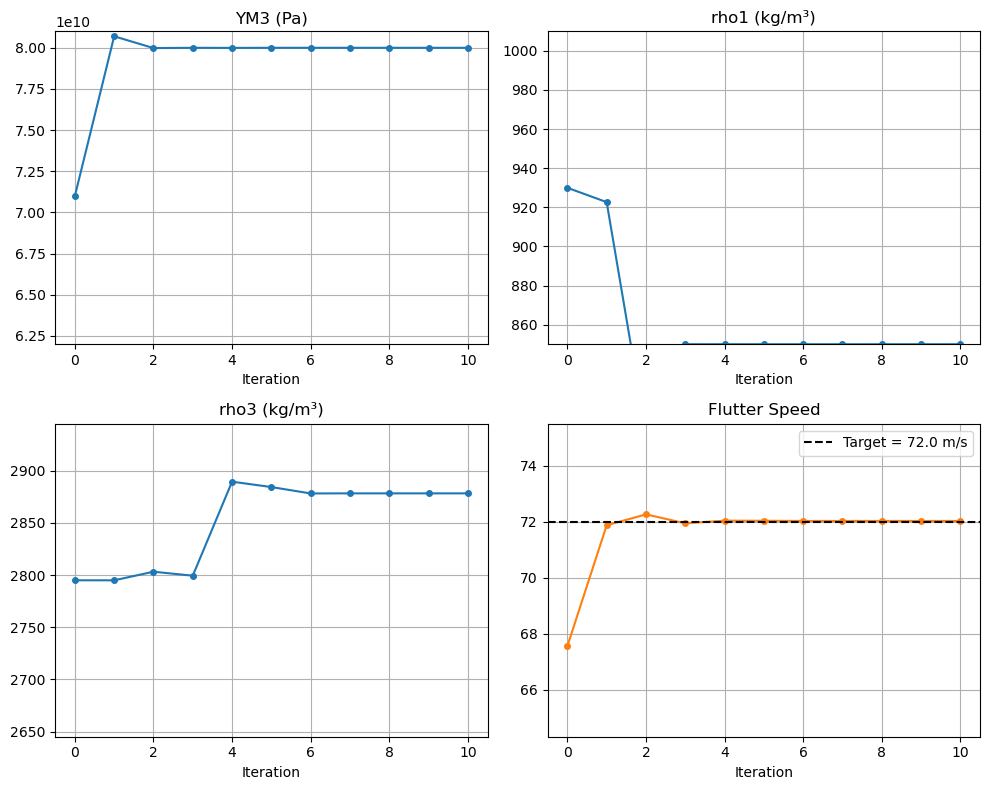

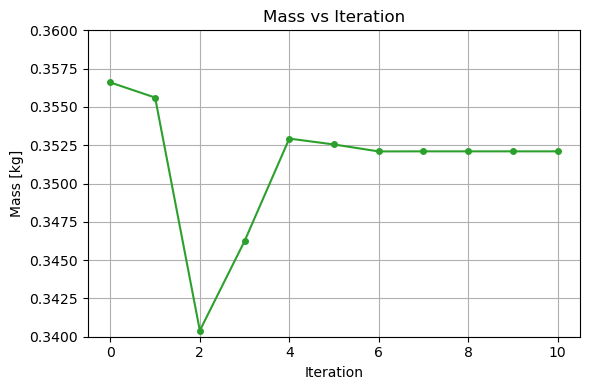

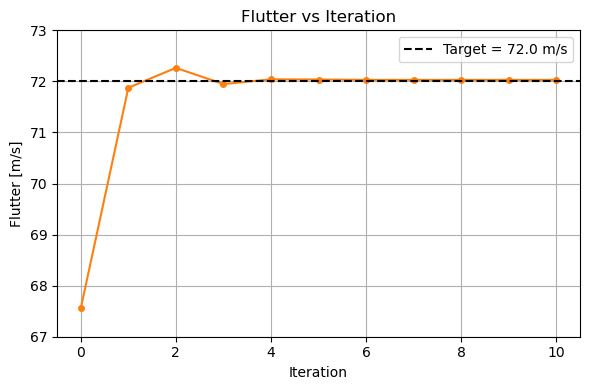

In [5]:
# ─────────────────────────────────────────────────────────────────────────────
# PLOTTING WITH DEFINED BOUNDS
# ─────────────────────────────────────────────────────────────────────────────
import numpy as np
import matplotlib.pyplot as plt

# Reconstruct histories
x_hist = np.array([y_to_x(y) for y in hist])
mass_history = []
flutter_history = []
for x in x_hist:
    m, fl = run_nastran_and_extract(x)
    mass_history.append(m)
    flutter_history.append(fl)

iters = np.arange(len(hist))
labels = ["YM3 (Pa)", "rho1 (kg/m³)", "rho3 (kg/m³)"]

# Define physical bounds
bounds = [
    (YM3_c - YM3_h, YM3_c + YM3_h+1e9),
    (r1_c  - r1_h,  r1_c  + r1_h),
    (r3_c  - r3_h,  r3_c  + r3_h),
]

# 2×2 grid: three variables + flutter
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
axs = axs.flatten()

for i in range(3):
    axs[i].plot(iters, x_hist[:, i], "-o", markersize=4)
    axs[i].set_title(labels[i])
    axs[i].set_xlabel("Iteration")
    axs[i].set_ylim(bounds[i])        # enforce your defined bounds
    axs[i].grid(True)

# Fourth subplot: flutter speed
axs[3].plot(iters, flutter_history, "-o", markersize=4, color="tab:orange")
axs[3].axhline(72, ls="--", color="k",
               label=f"Target = {72:.1f} m/s")
# Optionally, set a tight flutter range around your data:
min_fl, max_fl = min(flutter_history), max(flutter_history)
margin = 0.05 * (max_fl - min_fl)
axs[3].set_ylim(min_fl - margin-3, max_fl + margin+3)
axs[3].set_title("Flutter Speed")
axs[3].set_xlabel("Iteration")
axs[3].legend()
axs[3].grid(True)

plt.tight_layout()
plt.show()

# Separate Mass vs Iteration
plt.figure(figsize=(6,4))
plt.plot(iters, mass_history, "-o", markersize=4, color="tab:green")
plt.title("Mass vs Iteration")
plt.ylim(0.34, 0.36)
plt.xlabel("Iteration")
plt.ylabel("Mass [kg]")
plt.grid(True)
plt.tight_layout()
plt.show()

# Separate Flutter vs Iteration
plt.figure(figsize=(6,4))
plt.plot(iters, flutter_history, "-o", markersize=4, color="tab:orange")
plt.axhline(72, ls="--", color="k",
            label=f"Target = {72:.1f} m/s")
plt.ylim(67, 73)
plt.title("Flutter vs Iteration")
plt.xlabel("Iteration")
plt.ylabel("Flutter [m/s]")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Genetic Algorithm without Surrogate
import os
import shutil
import subprocess
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor, as_completed
from threading import Lock

# ─────────────────────────────────────────────────────────────────────────────
# 0) Globals and setup
# ─────────────────────────────────────────────────────────────────────────────
cache = {}
cache_lock = Lock()
case_counter = 0
case_counter_lock = Lock()

nastran = r'C:\Program Files\MSC.Software\MSC_Nastran\2024.2\bin\nastran.exe'
INPUT_DIR    = 'GA_inputs'
OUTPUT_DIR   = 'GA_outputs'
template_dat = 'sol145_combined3D.dat'

os.makedirs(INPUT_DIR, exist_ok=True)
os.makedirs(OUTPUT_DIR, exist_ok=True)

V_target = 69.938
ALPHA    = 100.0  # penalty weight

# bounds for design variables: E3, rho1, rho3
bounds = [
    (6.613e10, 7.587e10),   # E3
    (880.0,   980.0),        # rho1
    (2645.0,  2945.0)        # rho3
]

# ─────────────────────────────────────────────────────────────────────────────
# 1) Priority‐based fitness: maximize flutter onset, then minimize mass
# ─────────────────────────────────────────────────────────────────────────────
W_MASS    = 1.0        # weight on mass
W_FLUTTER = 50.0       # weight on flutter (tune this to taste)

def fitness(mass, flutter):
    # lower fitness is better: big negative for high flutter,
    # plus a small positive for mass
    return W_MASS*mass - W_FLUTTER*flutter

# ─────────────────────────────────────────────────────────────────────────────
# 2) Extract mass & flutter helpers (unchanged)
# ─────────────────────────────────────────────────────────────────────────────
def is_valid_data_line(parts):
    try:
        [float(p) for p in parts]
        return True
    except:
        return False

def extract_data_and_flutter(f06_path):
    lines = open(f06_path, 'r', encoding='utf-8', errors='ignore').readlines()
    mode_data = {m: [] for m in range(1,6)}
    for i, line in enumerate(lines):
        if "FLUTTER  SUMMARY" in line:
            mode = 1
            for parts in (l.split() for l in lines[i+5:]):
                if len(parts) >= 5 and is_valid_data_line(parts):
                    v, d, fr = float(parts[2]), float(parts[3]), float(parts[4])
                    if len(mode_data[mode]) < 121:
                        mode_data[mode].append((v, fr, d))
                    if len(mode_data[mode]) == 121:
                        mode += 1
                        if mode > 5:
                            break
    rows = []
    for m in range(1, 6):
        for v, fr, d in mode_data[m]:
            rows.append((m, v, fr, d))
    return rows

def extract_mass(f06_path):
    lines = open(f06_path, 'r', encoding='utf-8', errors='ignore').readlines()
    for i, line in enumerate(lines):
        if "O U T P U T" in line:
            parts = lines[i+3].split()
            if parts and parts[0] == '*':
                try:
                    return float(parts[1])
                except:
                    pass
    return None

def find_flutter(data):
    df = pd.DataFrame(data, columns=['Mode','V','F','D'])
    best = None
    for mode in sorted(df.Mode.unique()):
        sub = df[df.Mode == mode].sort_values('V')
        vs, ds = sub.V.values, sub.D.values
        for i in range(1, len(vs)):
            if ds[i-1] < 0 < ds[i]:
                sp = vs[i-1] - ds[i-1] * (vs[i] - vs[i-1]) / (ds[i] - ds[i-1])
                best = sp if best is None else min(best, sp)
                break
    return best

# ─────────────────────────────────────────────────────────────────────────────
# 3) Run Nastran and cache results
# ─────────────────────────────────────────────────────────────────────────────
def run_nastran_and_extract(x, Mach=0.15):
    key = (*np.round(x,6), round(Mach,3))
    with cache_lock:
        if key in cache:
            return cache[key]

    global case_counter
    with case_counter_lock:
        case_i = case_counter
        case_counter += 1

    print(f"[Case {case_i}] Starting run for x = {x}")
    folder = os.path.join(INPUT_DIR, f'Case_{case_i}')
    os.makedirs(folder, exist_ok=True)

    deck = open(template_dat, 'r', encoding='utf-8', errors='ignore') \
             .read().replace('MachPlc', f'{Mach:.3f}')
    nu_vals   = [0.394, 0.400, 0.330, 0.300, 0.394]
    E_vals    = [1.10e9, 4.67e8, x[0], 1e6, 1.10e9]
    rho_vals  = [x[1], 0.03, x[2], 0.001, 930.0]
    for i in range(5):
        deck = deck.replace(f'P{i+1}Plc',   f'{nu_vals[i]:.3f}') \
                   .replace(f'E{i+1}Plc',   f'{E_vals[i]:.6e}') \
                   .replace(f'rho{i+1}Plc', f'{rho_vals[i]:.4f}')

    dat = f'{case_i}_M{Mach:.3f}.dat'
    with open(os.path.join(folder, dat), 'w', encoding='utf-8') as f:
        f.write(deck)

    proc = subprocess.run(
        [nastran, dat],
        cwd=folder,
        stdout=subprocess.PIPE,
        stderr=subprocess.PIPE,
        text=True,
        timeout=3000
    )
    if proc.returncode != 0:
        raise RuntimeError(f"[Case {case_i}] Nastran error:\n{proc.stderr}")

    f06 = os.path.join(folder, dat.replace('.dat', '.f06'))
    if not os.path.exists(f06):
        raise FileNotFoundError(f"[Case {case_i}] .f06 not found")

    mass = extract_mass(f06)
    data = extract_data_and_flutter(f06)
    fl   = find_flutter(data)
    if mass is None or fl is None:
        raise RuntimeError(f"[Case {case_i}] Extraction failed")

    print(f"[Case {case_i}] mass = {mass:.6f}, flutter = {fl:.6f}")

    shutil.move(f06, os.path.join(OUTPUT_DIR, f'Case_{case_i}_M{Mach:.3f}.f06'))
    for fn in os.listdir(folder):
        if fn.lower().endswith(('.f04','.log','.xdb','.out')):
            os.remove(os.path.join(folder, fn))

    with cache_lock:
        cache[key] = (mass, fl)
    return mass, fl

# ─────────────────────────────────────────────────────────────────────────────
# 4) Rank population by fitness (returns sorted list of tuples)
# ─────────────────────────────────────────────────────────────────────────────
def rank_population(pop, Mach=0.15, workers=5):
    print(f"Evaluating population of {len(pop)} individuals with {workers} workers...")
    results = [None] * len(pop)
    with ThreadPoolExecutor(max_workers=workers) as exe:
        futures = {exe.submit(run_nastran_and_extract, pop[i], Mach): i
                   for i in range(len(pop))}
        for fut in as_completed(futures):
            idx = futures[fut]
            results[idx] = fut.result()
    print("Evaluation complete.")

    scored = []
    for x, (m, fl) in zip(pop, results):
        J = fitness(m, fl)
        scored.append((J, m, fl, x.copy()))

    scored.sort(key=lambda t: t[0])  # sort by fitness ascending
    return scored

# ─────────────────────────────────────────────────────────────────────────────
# 5) GA operators
# ─────────────────────────────────────────────────────────────────────────────
def SBX_crossover(p1, p2, eta_c=20):
    n = len(p1)
    c1, c2 = np.zeros(n), np.zeros(n)
    for i in range(n):
        u = random.random()
        beta = (2*u)**(1/(eta_c+1)) if u <= 0.5 else (1/(2*(1-u)))**(1/(eta_c+1))
        x1 = 0.5*((1+beta)*p1[i] + (1-beta)*p2[i])
        x2 = 0.5*((1-beta)*p1[i] + (1+beta)*p2[i])
        lo, hi = bounds[i]
        c1[i], c2[i] = np.clip(x1, lo, hi), np.clip(x2, lo, hi)
    return c1, c2

def polynomial_mutation(ind, eta_m=50, p_mut=0.1):
    for i in range(len(ind)):
        if random.random() < p_mut:
            lo, hi = bounds[i]
            delta1 = (ind[i] - lo) / (hi - lo)
            delta2 = (hi - ind[i]) / (hi - lo)
            u = random.random()
            mut_pow = 1/(eta_m+1)
            if u < 0.5:
                dq = (2*u + (1-2*u)*(1-delta1)**(eta_m+1))**mut_pow - 1
            else:
                dq = 1 - (2*(1-u) + 2*(u-0.5)*(1-delta2)**(eta_m+1))**mut_pow
            ind[i] += dq*(hi-lo)
            ind[i] = np.clip(ind[i], lo, hi)
    return ind

def init_pop(N=100):
    return [np.array([random.uniform(lo, hi) for lo, hi in bounds])
            for _ in range(N)]

# ─────────────────────────────────────────────────────────────────────────────
# 6) Run GA
# ─────────────────────────────────────────────────────────────────────────────
def run_ga(pop_size=100, gens=20, Mach=0.15, workers=5):
    pop    = init_pop(pop_size)
    x_hist, m_hist, f_hist = [], [], []

    for g in range(gens):
        print(f"--- Generation {g+1}/{gens} ---")
        scored = rank_population(pop, Mach, workers)
        J_best, m_best, fl_best, x_best = scored[0]

        x_hist.append(x_best.copy())
        m_hist.append(m_best)
        f_hist.append(fl_best)

        print(f"Gen {g+1}: J={J_best:.6f}, mass={m_best:.6f}, flutter={fl_best:.6f}")

        # produce next gen via tournament selection on fitness
        new_pop = [x_best.copy()]
        while len(new_pop) < pop_size:
            tournament = random.sample(scored, 4)
            parents = sorted(tournament, key=lambda t: t[0])[:2]
            c1, c2 = SBX_crossover(parents[0][3], parents[1][3])
            new_pop.append(polynomial_mutation(c1.copy()))
            if len(new_pop) < pop_size:
                new_pop.append(polynomial_mutation(c2.copy()))
        pop = new_pop

    return x_hist, m_hist, f_hist

# ─────────────────────────────────────────────────────────────────────────────
# 7) Main & plotting
# ─────────────────────────────────────────────────────────────────────────────
if __name__ == '__main__':
    x_hist, m_hist, f_hist = run_ga()

    best_x = x_hist[-1]
    print(f"Done. Optimal x = {best_x}")
    with open('ga_history.pkl', 'wb') as f:
        pickle.dump({
            'x_hist': x_hist,
            'm_hist': m_hist,
            'f_hist': f_hist
        }, f)
    print("GA histories saved to ga_history.pkl")
    # Mass history
    plt.figure(figsize=(6,4))
    plt.plot(m_hist, "-o", markersize=4, color="tab:green")
    plt.xlabel("Generation")
    plt.ylabel("Mass [kg]")
    plt.title("Best Mass per Generation")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

    # Flutter history
    plt.figure(figsize=(6,4))
    plt.plot(f_hist, "-o", markersize=4, color="tab:orange")
    plt.axhline(V_target, linestyle="--", color="k", label=f"Target {V_target:.1f} m/s")
    plt.xlabel("Generation")
    plt.ylabel("Flutter Speed [m/s]")
    plt.title("Best Flutter per Generation")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

    # Variables + Flutter over generations
    xs = np.array(x_hist)
    labels = ["E3", "ρ₁", "ρ₃"]
    limits = [(6.6e10,7.6e10),(860,1000),(2600,3000)]

    fig, axs = plt.subplots(2, 2, figsize=(10,8))
    axs = axs.flatten()
    for i, ax in enumerate(axs):
        if i < 3:
            ax.plot(xs[:, i], "-o", markersize=3)
            ax.set_title(f"{labels[i]} over Generations")
            ax.set_ylim(limits[i])
        else:
            ax.plot(f_hist, "-o", markersize=3, color="tab:orange")
            ax.axhline(V_target, linestyle="--", color="k")
            ax.set_title("Flutter Speed over Generations")
        ax.set_xlabel("Generation")
        ax.grid(True, linestyle="--", alpha=0.5)

    plt.tight_layout()
    plt.show()

--- Generation 1/20 ---
Evaluating population of 100 individuals with 5 workers...
[Case 0] Starting run for x = [7.09644011e+10 9.33538801e+02 2.89806752e+03]
[Case 1] Starting run for x = [6.85933939e+10 9.71204076e+02 2.67960202e+03]
[Case 2] Starting run for x = [7.51552503e+10 9.64903162e+02 2.91382335e+03]
[Case 3] Starting run for x = [6.70184415e+10 9.63475413e+02 2.70425578e+03]
[Case 4] Starting run for x = [7.32367694e+10 9.42004406e+02 2.87574044e+03]
[Case 2] mass = 0.370077, flutter = 69.330761
[Case 5] Starting run for x = [7.21591023e+10 9.32490229e+02 2.91344074e+03]
[Case 3] mass = 0.354328, flutter = 65.615141
[Case 6] Starting run for x = [6.94627477e+10 9.51909660e+02 2.87262680e+03]
[Case 0] mass = 0.364719, flutter = 67.571636
[Case 7] Starting run for x = [6.71265287e+10 9.75487450e+02 2.64792773e+03]
[Case 4] mass = 0.364192, flutter = 68.551027
[Case 8] Starting run for x = [6.69363935e+10 9.58046663e+02 2.72905177e+03]
[Case 1] mass = 0.353530, flutter = 66.3

In [ ]:
# replot_ga_results.py
# -*- coding: utf-8 -*-
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- 1) load your template so we know where the placeholders sat ---
template = open("sol145_combined3D.dat","r",encoding="utf-8").read()

# find the string‐indices of those placeholders in the template
pos_E3    = template.index("E3Plc")
pos_rho1  = template.index("rho1Plc")
pos_rho3  = template.index("rho3Plc")

# a tiny regex to pick up the scientific/decimal formats you used:
re_sci = re.compile(r"[+\-]?\d+\.\d+e[+\-]\d+")
re_dec = re.compile(r"\d+\.\d+")

# collect lists
hist_x, hist_m, hist_f = [], [], []

in_dir  = "GA_inputs"
out_dir = "GA_outputs"

for case in sorted(os.listdir(in_dir)):
    case_folder = os.path.join(in_dir, case)
    # there should be exactly one .dat file in each folder
    dat = next(f for f in os.listdir(case_folder) if f.lower().endswith(".dat"))
    dat_txt = open(os.path.join(case_folder, dat),"r",encoding="utf-8").read()

    # extract E3
    m = re_sci.search(dat_txt[pos_E3-1:pos_E3+15])
    E3    = float(m.group(0))

    # extract rho1
    m = re_dec.search(dat_txt[pos_rho1-1:pos_rho1+12])
    rho1  = float(m.group(0))

    # extract rho3
    m = re_dec.search(dat_txt[pos_rho3-1:pos_rho3+12])
    rho3  = float(m.group(0))

    # now read the matching .f06
    f06     = f"{case}_M0.150.f06"
    f06path = os.path.join(out_dir, f06)
    # you can re‐use your extract_mass / extract_data_and_flutter / find_flutter
    mass    = extract_mass(f06path)
    flutter = find_flutter_speed_from_data(extract_data_and_flutter(f06path))

    hist_x.append([E3, rho1, rho3])
    hist_m.append(mass)
    hist_f.append(flutter)

# build a DataFrame
df = pd.DataFrame(hist_x, columns=["E3","rho1","rho3"])
df["mass"]    = hist_m
df["flutter"] = hist_f

# save if you like
df.to_csv("GA_results_from_files.csv", index=False)
print("Saved GA_results_from_files.csv")

# now re‐plot exactly as before:

# a) mass
plt.figure(figsize=(6,4))
plt.plot(df["mass"], "-o", markersize=4, color="tab:green")
plt.xlabel("Generation")
plt.ylabel("Mass [kg]")
plt.title("Best Mass per Generation")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

# b) flutter with wide y‐limits
plt.figure(figsize=(6,4))
plt.plot(df["flutter"], "-o", markersize=4, color="tab:orange")
plt.axhline(V_target, linestyle="--", color="k", label=f"Target {V_target:.1f} m/s")
# expand around data
ymin, ymax = df["flutter"].min(), df["flutter"].max()
plt.ylim(ymin - 0.5, ymax + 0.5)
plt.xlabel("Generation")
plt.ylabel("Flutter Speed [m/s]")
plt.title("Best Flutter per Generation")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

# c) 2×2 of vars + flutter
fig, axs = plt.subplots(2,2, figsize=(10,8))
axs = axs.flatten()
labels = ["E3","ρ₁","ρ₃"]
limits = [(6.6e10,7.6e10),(880,980),(2645,2945)]
for i, ax in enumerate(axs):
    if i<3:
        ax.plot(df[labels[i]], "-o", markersize=3)
        ax.set_title(f"{labels[i]} over Generations")
        ax.set_ylim(limits[i])
    else:
        ax.plot(df["flutter"], "-o", markersize=3, color="tab:orange")
        ax.axhline(V_target, linestyle="--", color="k")
        ax.set_title("Flutter Speed over Generations")
    ax.set_xlabel("Generation")
    ax.grid(True, linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()


AttributeError: 'NoneType' object has no attribute 'group'